# **Backpropagation from Scratch**

In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from graphviz import Digraph
# for installation follow: https://stackoverflow.com/questions/46182603/graphviz-not-running-in-jupyter-notebook-python-3-6

## Derivation is at the heart of backpropagation
Derivation helps us understand how a function behaves if the input is modified. 
Given a function f(x), how does the function behave if input x is modified with h i.e x+h.

In case of backpropagation, the inputs are weights and biases. We want to understand what happens if small changes(h) are made to x(weights and biases)

### Now lets take a few examples to understand how the function behaviour changes upon increasing it with a small value

Example 1

In [3]:
def f(x):
  return 4*x**2 - 5*x + 6

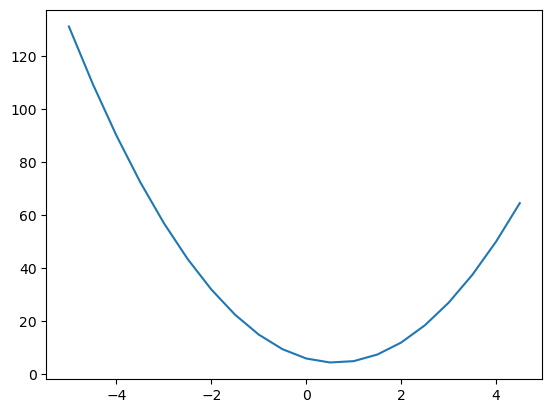

In [4]:
xs = np.arange(-5, 5, 0.5)
ys = f(xs)
plt.plot(xs, ys)

calculate the slope(f(x+h)-f(x))/h

In [5]:
# to get a more accurate slope, coverge h towards 0
x = 3.0
h = 0.00001
(f(x+h)-f(x))/h

19.000039999639284

Example 2

In [6]:
# observe the values when a is increased

def f1(a, b, c):
  return (a * b) + c

h = 0.0001

a = 2.0
b = -3.0
c = 10.0

d1 = f1(a, b, c)
d2 = f1(a+h, b, c)

# slope when a is increased by h
print("slope when a is increased: ",(d2-d1)/h)

d2 = f1(a, b+h, c)
# slope when b is increased by h
print("slope when b is increased: ",(d2-d1)/h)

d2 = f1(a, b, c+h)
# slope when c is increased by h
print("slope when c is increased: ",(d2-d1)/h)

slope when a is increased:  -3.000000000010772
slope when b is increased:  2.0000000000042206
slope when c is increased:  0.9999999999976694


### Neural Networks have massive expressions so lets create a data structure to maintain these expressions

In [7]:
class Operand:
    def __init__(self, value, _children = (), _operation='', _label = ''):
        self.value = value
        self.gradient = 0.0
        self._backward = lambda: None
        self._prev_ops = set(_children)
        self._operation = _operation
        self._label = _label
    
    def __repr__(self):
        return f"Variable(value={self.value})"

    # adding two operands
    def __add__(self, other):
        other = other if isinstance(other, Operand) else Operand(other)
        addition = Operand(self.value + other.value, (self, other), '+')

        def _backward():
            self.gradient += 1.0 * addition.gradient
            other.gradient += 1.0 * addition.gradient

        addition._backward = _backward
        return addition

    def __neg__(self):
        return -1 * self

    # subtracting two operands
    def __sub__(self, other):
        return self + (-other)
        
    # multiplying two operands
    def __mul__(self, other):
        other = other if isinstance(other, Operand) else Operand(other)
        product = Operand(self.value * other.value, (self, other), '*')
        def _backward():
            self.gradient += other.value * product.gradient
            other.gradient += self.value * product.gradient
        
        product._backward = _backward
        return product

    def __rmul__(self, other):
        return self * other

    # dividing two operands
    def __truediv__(self, other):
        # a * b = a * (b ** -1)
        return self * other**-1

    def __pow__(self, other):
        pow_y = Operand(self.value**other, (self, ), f'**{other}')

        def _backward():
            self.gradient += (other * self.value ** (other - 1)) * pow_y.gradient

        pow_y._backward = _backward
        return pow_y

    def exp(self):
        x = self.value
        exp_y = Operand(math.exp(x), (self,), 'exp')

        def _backward():
            # derivative of e**x is e**x
            self.gradient += exp_y.value * exp_y.gradient
        
        exp_y._backward = _backward
        return exp_y

    def tanh(self):
        x = self.value
        tanh_x = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        y = Operand(tanh_x, (self, ),'tanh')

        def _backward():
            self.gradient += (1 - tanh_x**2) *  y.gradient

        y._backward = _backward
        return y

    
    def backward(self):
        # backward pass for a node
        topo_sort = []
        visited = set()
        def build(node):
            if node not in visited:
                visited.add(node)
                for child in node._prev_ops:
                    build(child)

                topo_sort.append(node)

        build(self)

        self.gradient = 1.0
        for node in reversed(topo_sort):
            node._backward()

calculating loss for a simple expression

In [8]:
a = Operand(2.0, _label='a')
b = Operand(-3.0, _label='b')
c = Operand(8.0, _label='c')
d = a*b
d._label = 'd'
e = d + c
e._label='e'
f = Operand(-2.0, _label='f')

# Loss function
L = e * f; L._label='L'
L

Variable(value=-4.0)

Visualizing Loss with a graph

In [9]:
def trace(root):
    nodes = set()
    edges = set()
    def build_graph(node):
        if node not in nodes:
            nodes.add(node)
            for child in node._prev_ops:
                edges.add((child, node))
                build_graph(child)
    build_graph(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    for node in nodes:
        nid = str(id(node))
        dot.node(name=nid, label = "{%s | value %.4f | gradient %.4f}" % ( node._label, node.value, node.gradient), shape='record')
        if node._operation:
            dot.node(name=nid + node._operation, label=node._operation)
            dot.edge(nid + node._operation, nid)
    
    for e1, e2 in edges:
        dot.edge(str(id(e1)), str(id(e2)) + e2._operation)
    
    return dot

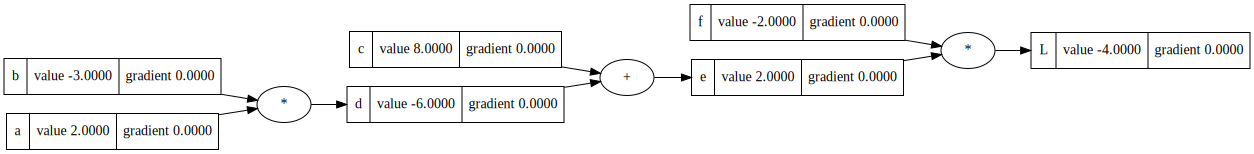

In [10]:
draw_dot(L)

### Lets calculate gradients manually 
In the above example, a and b is the fixed data i.e the input to the NN, while c, d, e, f are the weights.

**What should be the values of weights so the loss is minimized? Derivativation will help us find that out.**

Example 1

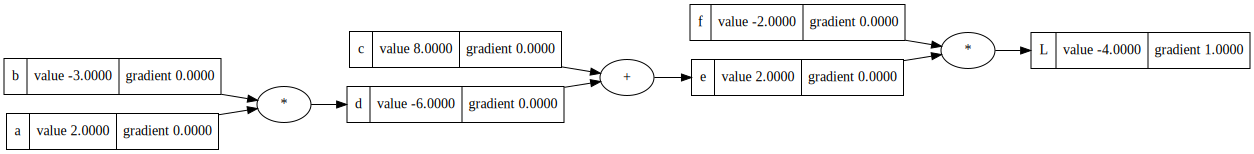

In [11]:
# derivative of variable w.r.t to itself is 1 so derivative of L w.r.t itself will be 1
L.gradient = 1.0
draw_dot(L)

**dL/de = ?**

for y = f(x), dy/dx = (f(x+h) - f(x))/h

here, L = e * f

so, dL/de = ((e+h) * f - (e) * f)/h
          = (e*f + h*f -e*f)/h
          = (h*f)/h
          = f

therefore, dL/de = f

similarly it can be proved that dL/df = e

Note 1: for a multiplication operation **'a*b'**, the derivative of **a** will be **b** and derivative of **b** will be **a**

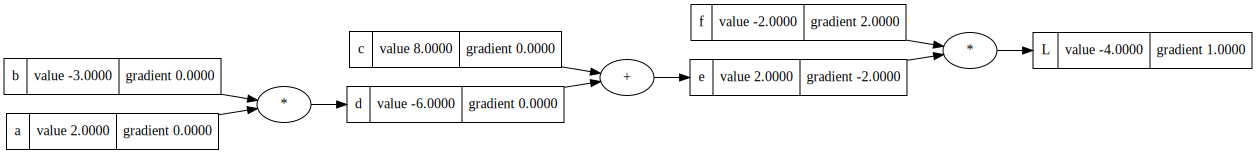

In [12]:
e.gradient = f.value
f.gradient = e.value

draw_dot(L)

**now lets calculate dL/dc by using [chain rule](https://en.wikipedia.org/wiki/Chain_rule)**
dL/dc = (dL/de) * (de/dc)

from the previous step we know that dL/de = f, 

de/dc = ?

here, e = c + d

so, de/dc = ((c+h) + d) - (c+d)/ h
          = (c + h + d - c - d )/h
          = h/h 
          = 1.0

therefore, dL/dc = (dL/de) * (de/dc)
                 = f * 1.0
                 = f

similary it can be proved that de/dd = 1.0 

therefore dL/dd = f

Note 2: for addition, **'a + b'**, the deriavtive will **a** as well as **b** will be **1**


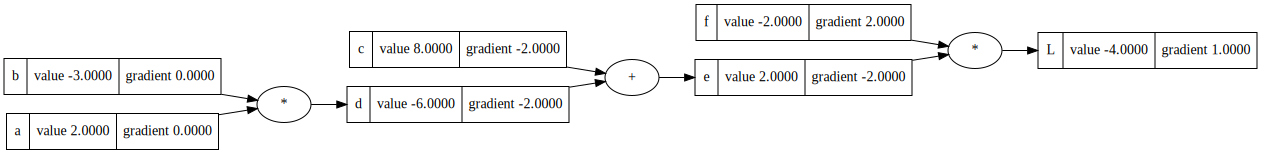

In [13]:
c.gradient = f.value
d.gradient = f.value

draw_dot(L)

now lets calcualte **dL/da**

dL/da = dL/dd * dd/da

from previous step, we know that dL/dd = f 

and from **Note 1**, we can surmise that dd/da will be **b**

therefore dL/da = f * b

similarly it can be proved that, dL/db = f * a


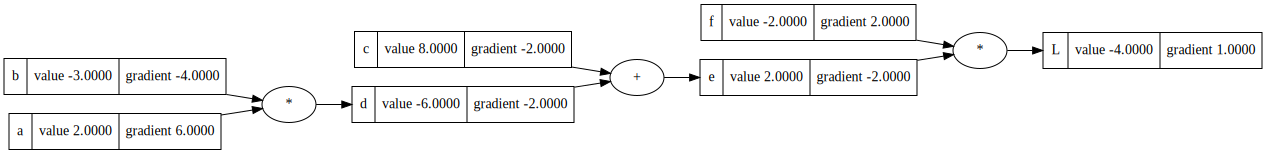

In [14]:
a.gradient = f.value * b.value
b.gradient = f.value * a.value

draw_dot(L)

Example 2

Observe how the loss is affected: as we change the operands by a small value, the loss will go up

In [15]:
a.value += 0.01 * a.gradient
b.value += 0.001 * b.gradient
c.value += 0.001 * c.gradient
f.value += 0.001 * f.gradient

d = a*b
e = d + c
L = e * f

L

Variable(value=-3.6159004799999996)

## Neural Networks are made up of layers of neurons

### Backpropagation through a Neuron

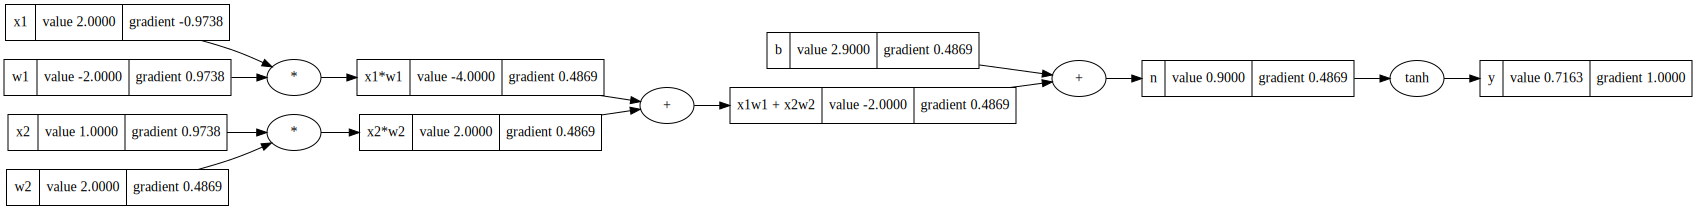

In [16]:
# single neuron

# inputs: x1, x2
x1 = Operand(2.0, _label='x1')
x2 = Operand(1.0, _label='x2')

# weights: w1, w2
w1 = Operand(-2.0, _label='w1')
w2 = Operand(2.0, _label='w2')

# bias
b = Operand(2.9, _label='b')

# loss: x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1._label ='x1*w1'
x2w2 = x2 * w2; x2w2._label = 'x2*w2' 
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2._label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n._label = 'n'

y = n.tanh(); y._label='y'
y.backward()
draw_dot(y)

practicing backpropagation with more expressions

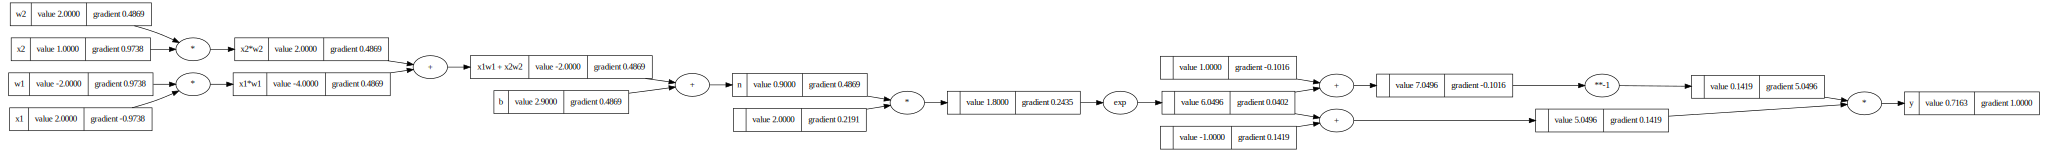

In [17]:
# inputs: x1, x2
x1 = Operand(2.0, _label='x1')
x2 = Operand(1.0, _label='x2')

# weights: w1, w2
w1 = Operand(-2.0, _label='w1')
w2 = Operand(2.0, _label='w2')

# bias
b = Operand(2.9, _label='b')

# loss: x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1._label ='x1*w1'
x2w2 = x2 * w2; x2w2._label = 'x2*w2' 
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2._label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n._label = 'n'

# y = n.tanh(); y._label='y'
# using formula for tanh
e = (2*n).exp()
y = (e-1)/(e+1)
y._label = 'y'

y.backward()
draw_dot(y)

In [18]:
class Neuron:
    def __init__(self, n_inp):
        self.weights = [Operand(random.uniform(-1, 1)) for _in in range(n_inp)]
        self.bias = Operand(random.uniform(-1,1))

 __Reference: [Neural Networks: Zero to Hero by **Anderj Karpathy**](https://youtu.be/VMj-3S1tku0?si=nt0sYb9Rs2g4qApr)__